# Box Cox transform

In this notebook we show how to apply a Box Cox transform to stabilise the 
variance of a time series manually, using the MLE method, and using the Guerrero method.

# Data set synopsis

The air passengers dataset is the monthly totals of US airline passengers, from 1949 to 1960, in units of 1000s. 

For instructions on how to download, prepare, and store the dataset, refer to notebook number 1, in the folder "01-Create-Datasets" from this repo.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_context('talk')

# Load data

In [2]:
data = pd.read_csv(
    "../Datasets/example_air_passengers.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

# Plot the data

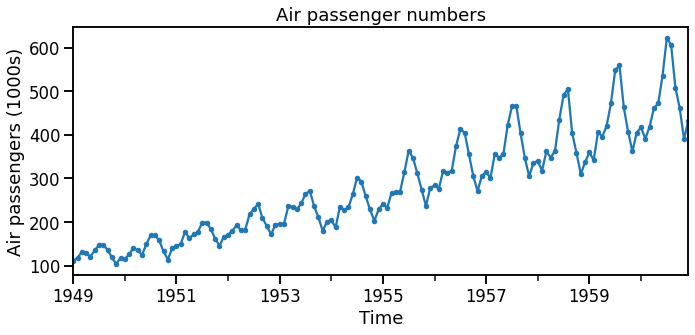

In [3]:
fig, ax = plt.subplots(figsize=[10, 5])
data.plot(y="y", marker=".", figsize=[10, 5], legend=None, ax=ax)
ax.set_xlabel('Time')
ax.set_ylabel('Air passengers (1000s)')
ax.set_title('Air passenger numbers')
plt.tight_layout()

# Apply Box Cox transform using scipy

The Box Cox transform is defined as:

$${\displaystyle y_{i}^{(\lambda )}={\begin{cases}{\dfrac {y_{i}^{\lambda }-1}{\lambda }}&{\text{if }}\lambda \neq 0,\\\ln y_{i}&{\text{if }}\lambda =0,\end{cases}}}$$

Let's apply the Box Cox transform to the air passengers data and see what the results look like.

In [4]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [5]:
df = data.copy() # Make a copy of data so we can re-use data later
df['y_boxcox'] = boxcox(df['y'], lmbda=0) # Equivalent to a log transform

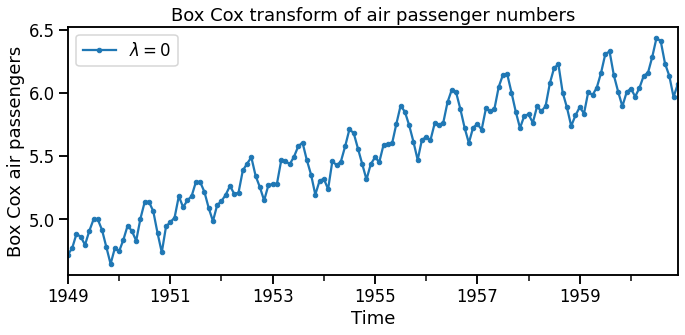

In [6]:
# Plot the box cox transformed time series
fig, ax = plt.subplots(figsize=[10, 5])
df.plot(y="y_boxcox", marker=".", figsize=[10, 5], label='$\lambda=0$', ax=ax)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Box Cox air passengers')
ax.set_title('Box Cox transform of air passenger numbers')
plt.tight_layout()

We can let scipy automatically find a good value for `lmbda` by setting the `lmbda`
argument in boxcox to `None`. This happens by default by omitting the `lmbda` argument. Scipy uses the maximum likelihood method to automatically select a good value for `lmbda`. 

In [7]:
df['y_boxcox'], lmbda = boxcox(df['y'], lmbda=None)
print(f"Lambda was automatically set to {lmbda:.3f}")
df.head()

Lambda was automatically set to 0.148


,y,y_boxcox
ds,,
1949-01-01,112,6.827490
1949-02-01,118,6.932822
1949-03-01,132,7.161892
1949-04-01,129,7.114611
1949-05-01,121,6.983787


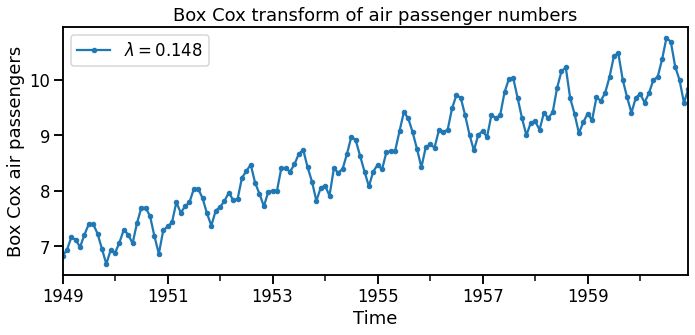

In [8]:
fig, ax = plt.subplots(figsize=[10, 5])
df.plot(y="y_boxcox", marker=".", figsize=[10, 5], label=f"$\lambda={lmbda:.3f}$", ax=ax)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Box Cox air passengers')
ax.set_title('Box Cox transform of air passenger numbers')
plt.tight_layout()

Let's compute the Box Cox transform for multiple different parameters of lambda.

In [9]:
lmbdas = [
    -1, # Inverse transform y^(-1)
    -0.5, # inverse square root transform y^(-1/2)
    0,  # Log transform ln(y)
    0.5, # Square root transform sqrt(y)
    1,   # y - 1
    2, # Square transform y^2
  ]

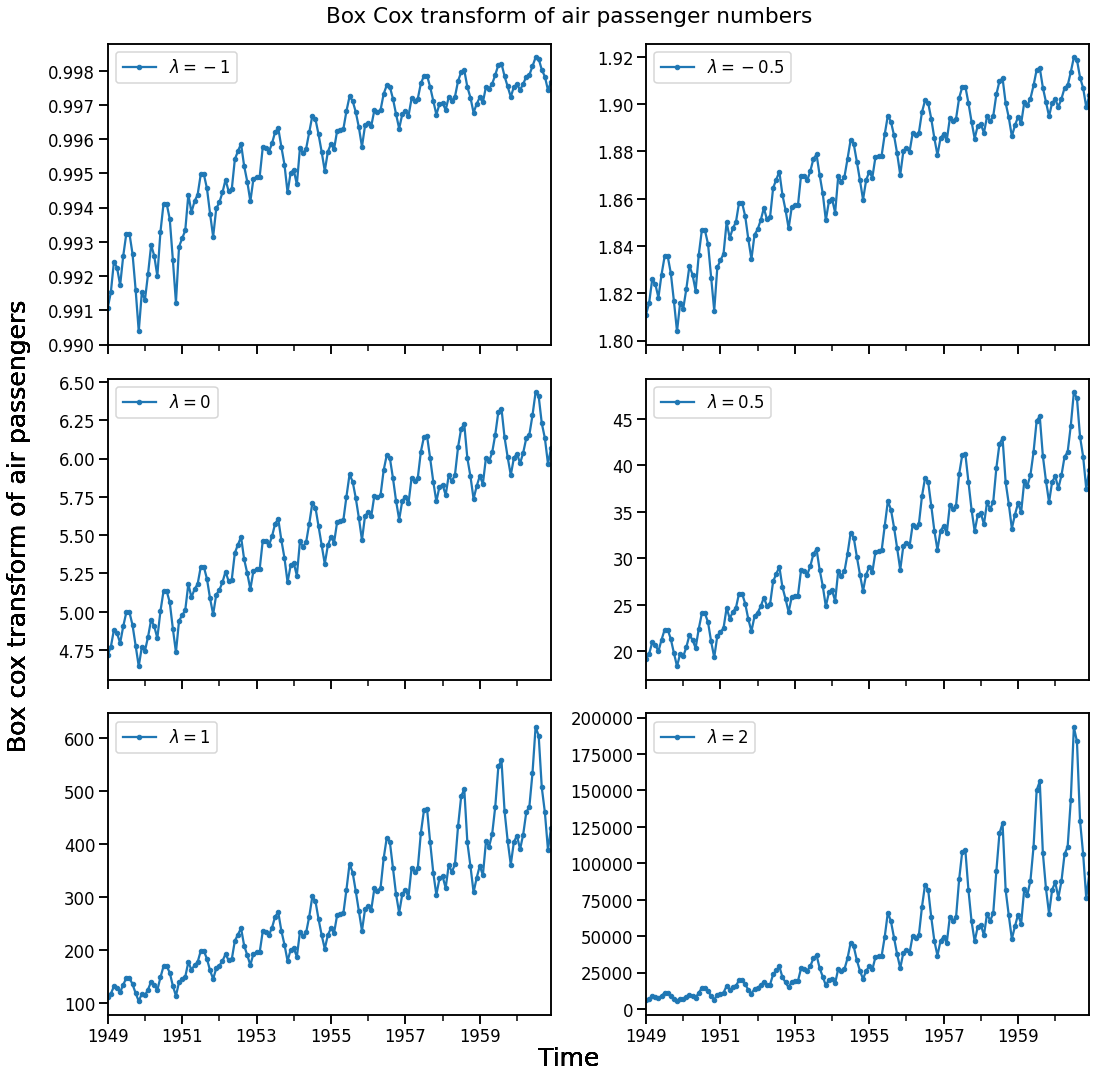

In [10]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=[15, 15], sharex=True)
ax = ax.flatten()
for ix, lmbda in enumerate(lmbdas):
    df[f"y_{lmbda}"] = boxcox(df['y'], lmbda=lmbda) # Compute Box Cox transform
    df.plot(y=f"y_{lmbda}", marker=".", label=f'$\lambda={lmbda}$', ax=ax[ix])
    ax[ix].legend()
    ax[ix].set_xlabel('')
    fig.suptitle('Box Cox transform of air passenger numbers')
    fig.text(0.5, 0, "Time", ha="center", fontsize=25)
    fig.text(-0.02, 0.5, "Box cox transform of air passengers", va="center", rotation="vertical", fontsize=25)
    
    plt.tight_layout()


We might want to perform the inverse transform to recover the original data. This
can be done by using the `inv_boxcox` method from Scipy.

In [11]:
df['y_recovered'] = inv_boxcox(df['y_-1'], -1) # The second parameter is the value of
                                               # lambda used in the box cox transform

In [12]:
df[['y', 'y_recovered']].head()

,y,y_recovered
ds,,
1949-01-01,112,112.0
1949-02-01,118,118.0
1949-03-01,132,132.0
1949-04-01,129,129.0
1949-05-01,121,121.0


# Box Cox with sktime 

We show how to use the Box Cox transformer from sktime which allows us
to use the Guerrero method to select $\lambda$. 

In [13]:
from sktime.transformations.series.boxcox import BoxCoxTransformer

In [14]:
transformer = BoxCoxTransformer(method='guerrero',
                                sp=12) # sp should be set to the seasonal period

df['y_guerrero'] = transformer.fit_transform(df['y'])
transformer.lambda_

-0.2947236481659704

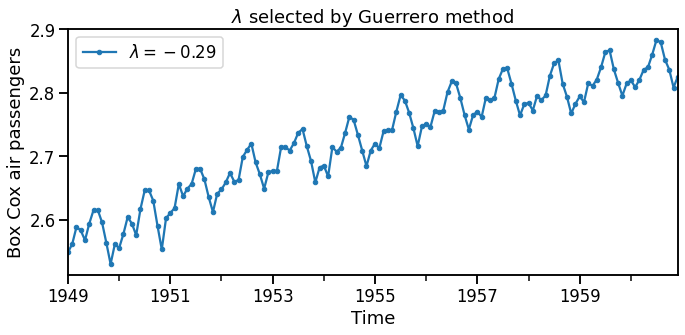

In [15]:
fig, ax = plt.subplots(figsize=[10, 5])
df.plot(y="y_guerrero", marker=".", figsize=[10, 5], label=f'$\lambda={transformer.lambda_:.2f}$', ax=ax)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Box Cox air passengers')
ax.set_title('$\lambda$ selected by Guerrero method')
plt.tight_layout()

You can also use the MLE method.

In [16]:
transformer = BoxCoxTransformer(method='mle')
y_hat = transformer.fit_transform(df['y'])
df['y_mle'] = y_hat 
transformer.lambda_

0.14802265137037945

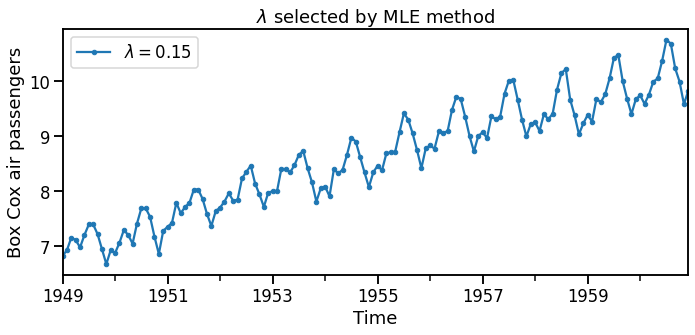

In [17]:
fig, ax = plt.subplots(figsize=[10, 5])
df.plot(y="y_mle", marker=".", figsize=[10, 5], label=f'$\lambda={transformer.lambda_:.2f}$', ax=ax)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Box Cox air passengers')
ax.set_title('$\lambda$ selected by MLE method')
plt.tight_layout()

# Box Cox with Feature-engine

We might want to apply the Box Cox transform to multiple variables and as part 
of a pipeline. This can be easily done by using the Box Cox transformer from 
Feature-engine. Scipy is used under the hood and so the MLE method is used to pick $\lambda$.

In [18]:
from feature_engine.transformation import BoxCoxTransformer

In [19]:
df = data.copy()
# Add a new column to show Box Cox transformer handling two columns
df['x'] = df['y'] * 2

In [20]:
tf = BoxCoxTransformer(variables=["y", "x"])
df[['y_boxcox', "x_boxcox"]] = tf.fit_transform(df)
df.head()

,y,x,y_boxcox,x_boxcox
ds,,,,
1949-01-01,112,224,6.827490,8.295150
1949-02-01,118,236,6.932822,8.411863
1949-03-01,132,264,7.161892,8.665684
1949-04-01,129,258,7.114611,8.613294
1949-05-01,121,242,6.983787,8.468335


We can access the value of lambda that was automatically selected using the `lambda_dict_`
attribute.

In [21]:
tf.lambda_dict_

{'y': 0.14802265137037945, 'x': 0.14802255370969325}